In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad 
import scipy as sp

# Rotation on a circle

The stochastic equation is: $x_{t +1} = x_t + \nu + \omega t$
where $\nu$ is a fixed rotation angle and $\omega_t\sim Uniform[-0.5, 0.5]$. The function below generates a trajectory for number of time steps T, with rotation angle $\nu$ and initial condition $x_0$.

In [2]:
def circle_rotation(x0, T, nu, noise):
    solution  = np.zeros(T)
    solution[0] = x0
    for i in range(1, T):
        # draw random number
        omega = np.random.rand() - 0.5
        # update
        solution[i] =np.mod(solution[i - 1] + nu + omega + noise*np.random.normal(), 2*np.pi)
    return solution

Generate the SKO and the DKO data. The densities will be uniform on the interval $[0, 2\pi]$ i.e.
$$\pi_j = Unif{\Big[j\frac{2\pi}{m},(j + 1)\frac{2\pi}{m}\Big]}, j \in \{0, \dots, m - 1\}$$

SKO data: one long trajectory of length T_SKO starting at 0. Since we compute K_10 we take every tenth entrance of the trajectory for the DMD computation

DKO data: K samples for each m measures, each sample is propagated in time for time T_DKO

Parameter Dt keeps track of which Koopman operator we are approximating i.e. we approximate $K_{Dt}$

In [3]:
# number of samples per measure
K = 1000

# length of trajectory = Delta t
T_SKO = 10000

# number of measures
m = 20

# parameter for rotations
nu = 0.5

# noise level
noise = 0

# number of observables
n = 100

# Delta t
Dt = 1

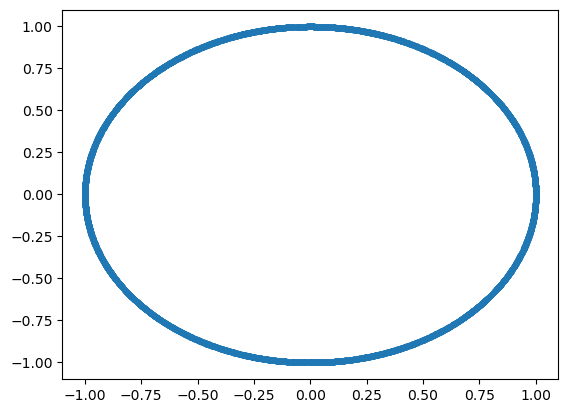

In [50]:
# generate the long trajectory
data_SKO = circle_rotation(0, T_SKO, 0.5, noise)

# take every 10th entry
data_SKO = data_SKO[::Dt]

# compute how long the SKO trajectory is
n_SKO = np.shape(data_SKO)
n_SKO = n_SKO[0]
plt.plot(np.cos(data_SKO), np.sin(data_SKO),'.')


In [51]:
# generate samples from each measure, store them in data_DKO_0, propagate forward Dt time steps and store in data_DKO_1
data_DKO_0 = np.zeros((K, m))
data_DKO_1 = np.zeros((K, m))
for j in range(m):
    for k in range(K):
        # generate initial condition
        x0 = j* 2 * np.pi / m +  2 * np.pi / m * np.random.uniform()

        # store
        data_DKO_0[k, j] = x0

        # compute the trajectory
        solution = circle_rotation(x0, Dt + 1, 0.5, noise)

        #store
        data_DKO_1[k, j] = solution[-1]

For the observables we choose $h_l(\pi)= \pi(\left[ 2\pi \frac{l}{n},2\pi \frac{l}{n + 1}\right])$ for $l = 1, \dots, n$ and $n$ is the number of observables defined before. We then compute the $E = h_i(\pi_j)$ and $D = h_i(\mu_j)$ matrices

In [52]:
E_DKO = np.zeros((n, m))
D_DKO = np.zeros((n, m))
# for each measure find how many points are within each interval
for j in range(m):
    counts0, _ = np.histogram(data_DKO_0[:, j], bins = np.linspace(0, 2*np.pi, n + 1))
    E_DKO[:, j] = counts0/K
    counts1, _ = np.histogram(data_DKO_1[:, j], bins = np.linspace(0, 2*np.pi, n + 1))
    D_DKO[:, j] = counts1/K

Perform the DMD algorithm for DKO: $K_{n,m}  = DE^\dagger$ 

In [53]:
K_DKO = D_DKO@np.linalg.pinv(E_DKO)

For the DMD algorithm for SKO we need to compute $h(x_j)$ for each $x_j$ in the long trajectory data_SKO. As observables we choose the indicator functions $\hat{h}_i = \chi \left[ 2\pi \frac{l}{n},2\pi \frac{l}{n + 1}\right]$

In [54]:
E_SKO = np.zeros((n, n_SKO))
for i in range(n):
   for j in range(n_SKO):
        if (2*np.pi* i/n <=  data_SKO[j]) & (data_SKO[j] < 2*np.pi* (i + 1)/n): 
                E_SKO[i, j] = 1


Perform the DMD algorithm for SKO: $K_SKO = E_{SKO}[1:] E_{SKO}[0: -1]^\dagger$

In [55]:
K_SKO = E_SKO[:, 1:] @ np.linalg.pinv(E_SKO[:, :-1])

We now compare the DKO vs the SKO. We start by looking at the eigenvalues. The true eigenfunctions and eigenvalues are:
$$\hat{h}_i(x) = e^{inx}, \lambda_i = \left(\frac{e^{ni} - 1}{in}\right)^{Dt}$$

In [56]:
eval_SKO, evect_SKO = np.linalg.eig(K_SKO)
eval_DKO, evect_DKO = np.linalg.eig(K_DKO)

<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:15: SyntaxWarning: invalid escape sequence '\l'
/var/folders/c1/rxks_11d2njc18dkmqh0_37m0000gn/T/ipykernel_42233/196087818.py:14: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$Re(\lambda)$", fontsize=16)
/var/folders/c1/rxks_11d2njc18dkmqh0_37m0000gn/T/ipykernel_42233/196087818.py:15: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$Im(\lambda)$', fontsize=16)


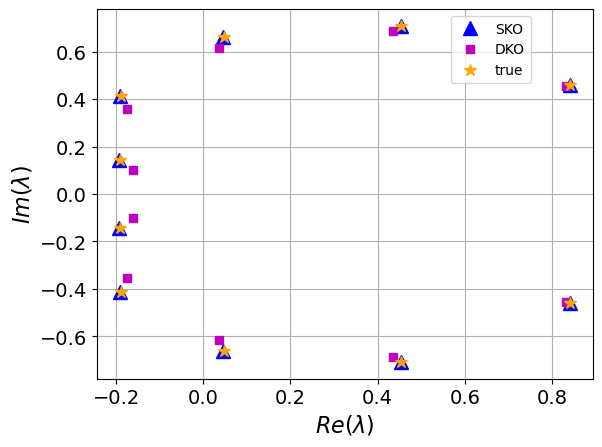

<Figure size 640x480 with 0 Axes>

In [57]:
number_evals_to_show = 11
plt.plot(np.real(eval_SKO[1:number_evals_to_show]), np.imag(eval_SKO[1:number_evals_to_show]), 'b^',markersize=10, label = "SKO")
plt.plot(np.real(eval_DKO[1:number_evals_to_show]), np.imag(eval_DKO[1:number_evals_to_show]), 'ms',markersize=6, label = "DKO")

#plt.plot(np.real(eval_DKO), np.imag(eval_DKO), '.', label = 'DKO')
#plt.plot(np.real(eval_SKO), np.imag(eval_SKO), '.', label = 'DKO')

x = np.arange(number_evals_to_show/2 - 1)
true_evals = ((np.cos(x + 1) - 1 + np.sin(x + 1)*1j)/((x + 1)*1j))**Dt
plt.plot(np.real(true_evals), np.imag(true_evals), '*', color='orange', markersize=9, label="true")
plt.plot(np.real(true_evals), -np.imag(true_evals), '*', color='orange', markersize=9)
#plt.title("Noise "+str(noise))
plt.legend(loc='upper left', bbox_to_anchor=(0.7, 1))
plt.xlabel("$Re(\lambda)$", fontsize=16)
plt.ylabel('$Im(\lambda)$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.savefig("eigenvalues_circle.png")
plt.show()
plt.clf()

Plot the eigenfunctions: For SKO plot $evect_{SKO}*\mathcal{H}$ where $\mathcal{H} = \{\hat{h}_1, \dots, \hat{h}_n\}$. For DKO we plot the function that is being integrated in order to obtain the eigenfunction of $K_{DKO}$ i.e. if $h(\pi) = \int \hat{h} d\pi$ is the eigenfunction, we plot $\hat{h}$. First, we plot the SKO eigenfunctions and then the DKO ones.

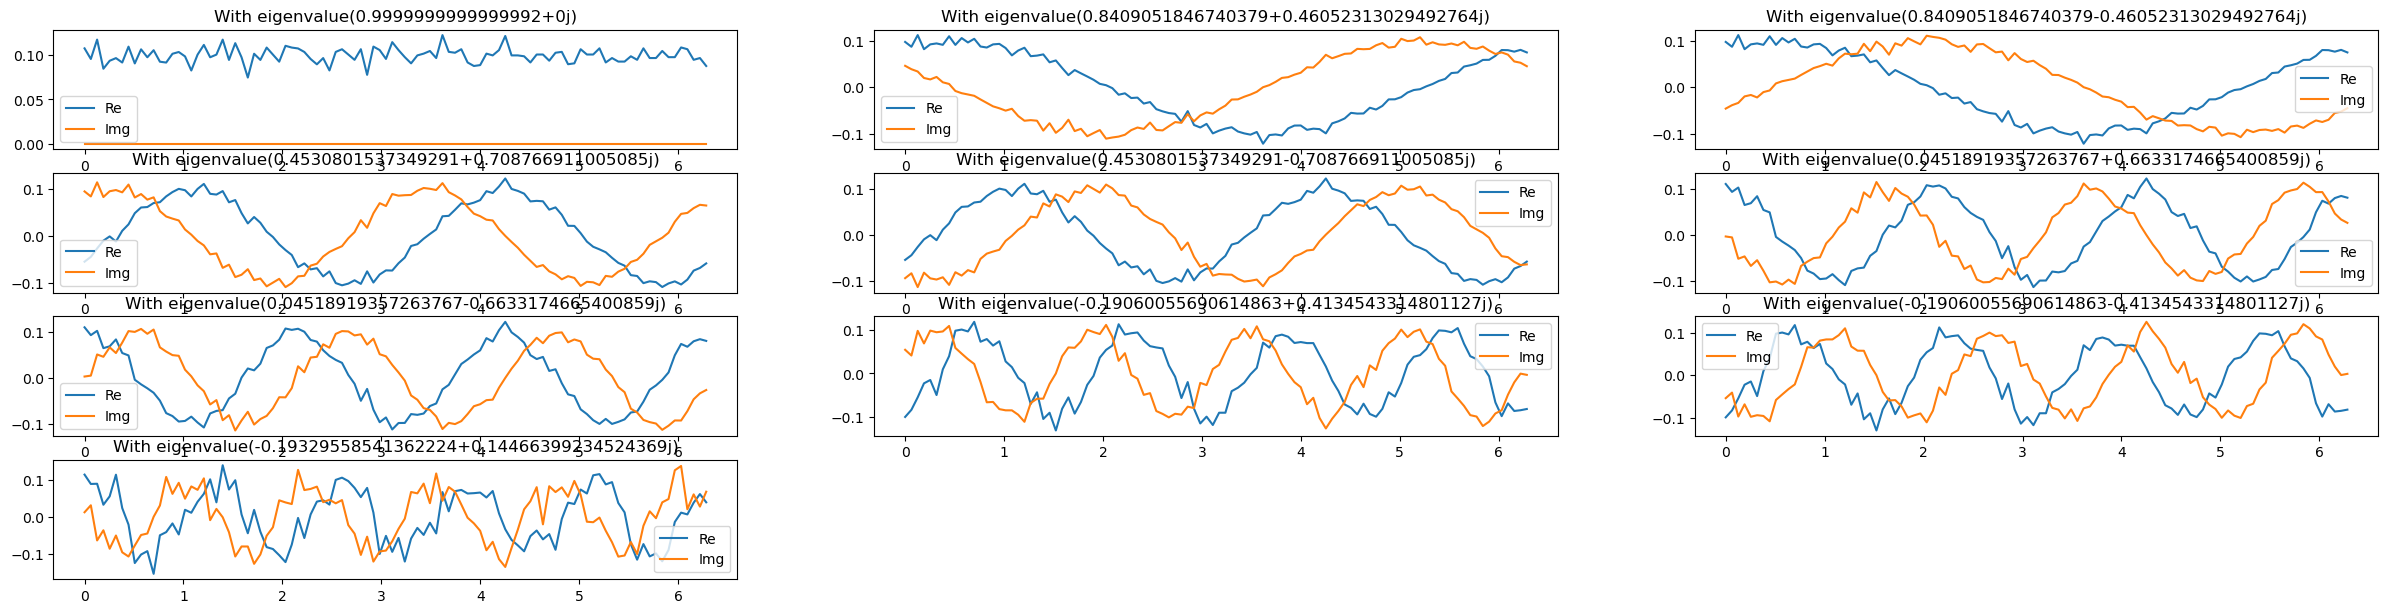

In [58]:
# settings to plot in a figure
fig, axes = plt.subplots(5, 3, figsize=(10 * 3, 3 * 3))  
axes = np.array(axes).flatten()  
x = np.linspace(0, 2*np.pi, 100)
for l in range(10):
    efun = np.zeros((100, ))
    for i in range(n):
        efun = efun +  evect_SKO[i, l]*np.where((2*np.pi* i/n <=  x) & (2*np.pi*(i + 1)/n >= x), 1, 0)
    axes[l].plot(x, np.real(efun), label = "Re")
    axes[l].plot(x, np.imag(efun), label = "Img")
    axes[l].set_title("With eigenvalue" +  str(eval_SKO[l]))
    axes[l].legend()
for j in range(10, len(axes)):
    fig.delaxes(axes[j])

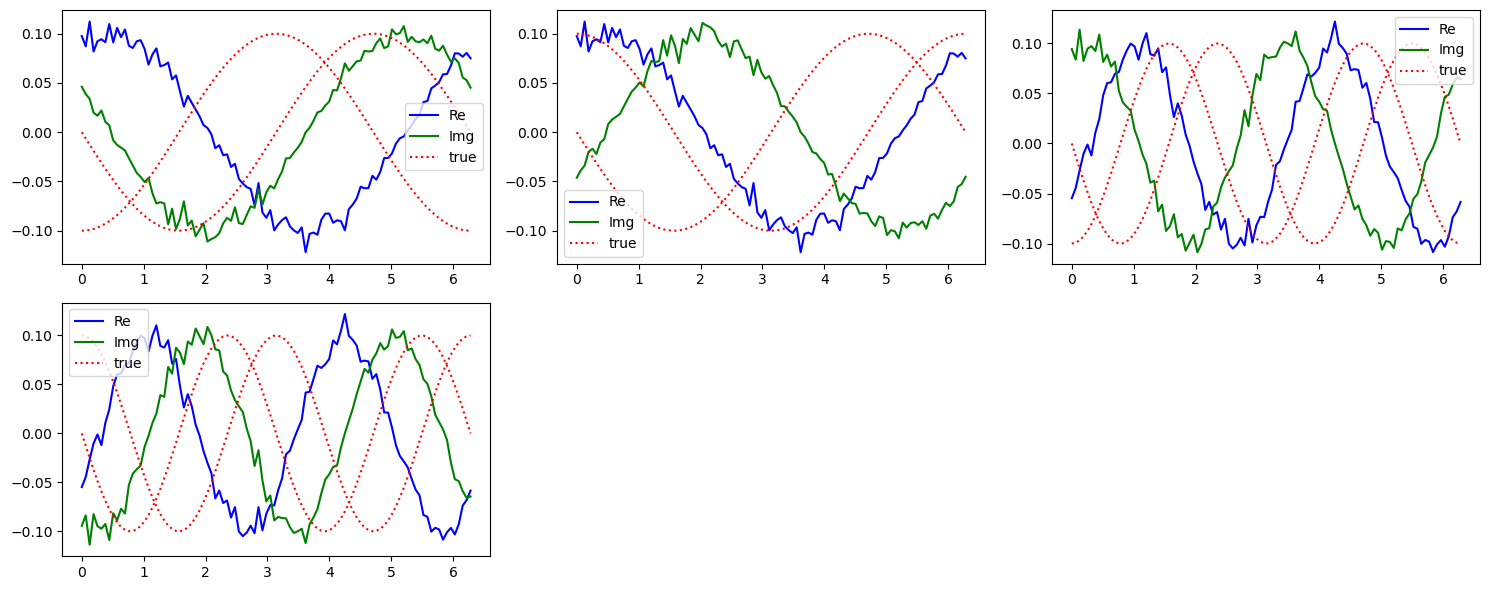

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  
axes = np.array(axes).flatten()  
#fig.delaxes(axes[0])
#axes = np.delete(axes, 0)
x = np.linspace(0, 2*np.pi, 100)
for l in range( 5):
    efun = np.zeros((100, ))
    for i in range(n):
        efun = efun +  evect_SKO[i, l + 1]*np.where((2*np.pi* i/n <=  x) & (2*np.pi*(i + 1)/n >= x), 1, 0)
    
    axes[l].plot(x, np.real(efun),'b',  label = "Re")
    axes[l].plot(x, np.imag(efun), 'g', label = "Img")
       # axes[l].set_title("With eigenvalue" +  str(eval_DKO[l + 1]))
    axes[l].legend()
    
for l in range(3):
    axes[2*l].plot(x,-0.1*np.cos(x*(l + 1)), 'red', linestyle = ":", label = "true")
    axes[2*l].plot(x, -0.1*np.sin(x*(l + 1)), 'red', linestyle = ":")
    axes[2*l + 1].plot(x, 0.1*np.cos(x* (l + 1)), 'red', linestyle = ":")
    axes[2*l + 1].plot(x, - 0.1*np.sin(x*( l + 1)), 'red', label = 'true', linestyle = ":")
    axes[l].legend()
axes[3].legend()

for j in range(4, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()

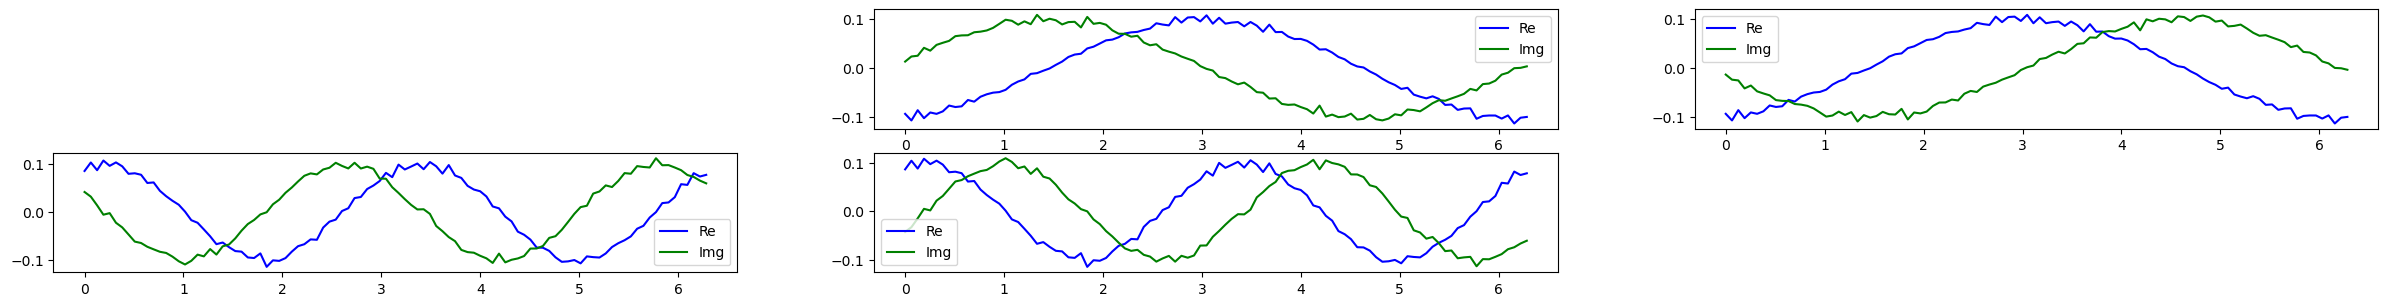

In [60]:
fig, axes = plt.subplots(5, 3, figsize=(10 * 3, 3 * 3))  
axes = np.array(axes).flatten()  
x = np.linspace(0, 2*np.pi, 100)
for l in range(1, 10):
    efun = np.zeros((100, ))
    for i in range(n):
        efun = efun +  evect_DKO[i, l]*np.where((2*np.pi* i/n <=  x) & (2*np.pi*(i + 1)/n >= x), 1, 0)
    axes[l].plot(x, np.real(efun),'b',  label = "Re")
    axes[l].plot(x, np.imag(efun), 'g', label = "Img")
    axes[l].legend()
    #axes[l].set_title("With eigenvalue" +  str(eval_DKO[l]))

for j in range(5, len(axes)):
    fig.delaxes(axes[j])
fig.delaxes(axes[0])



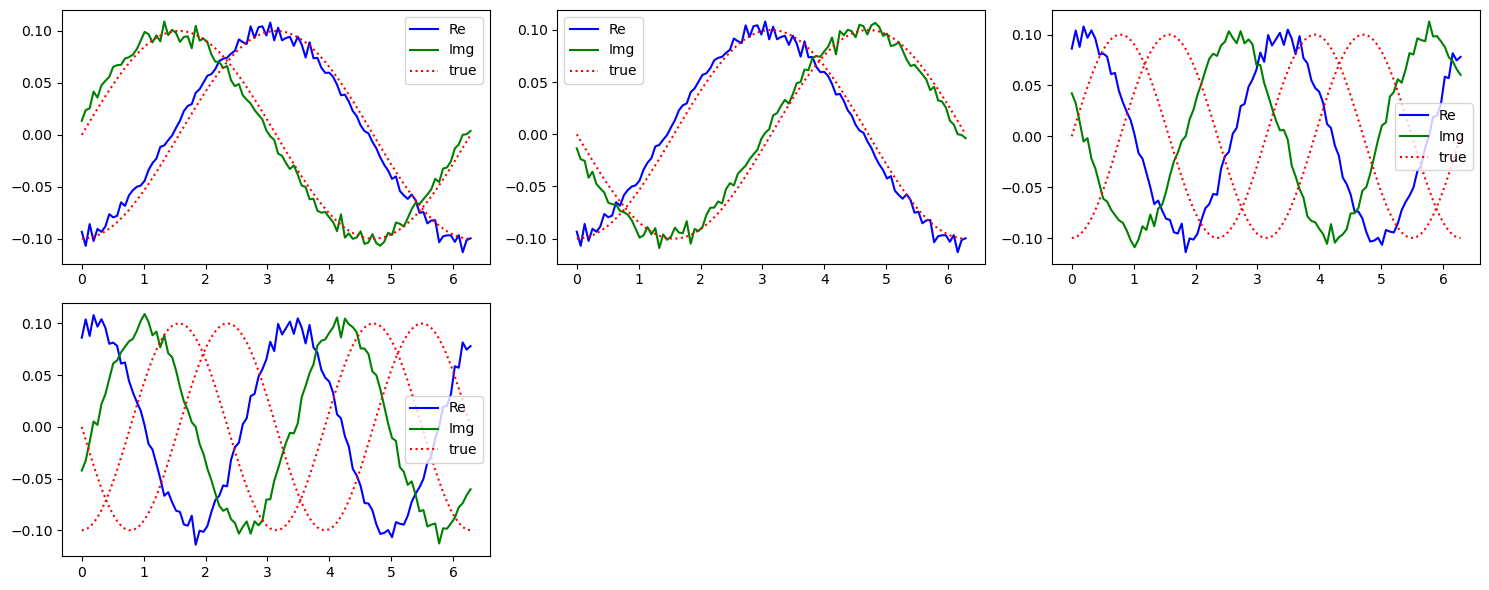

In [61]:
fig, axes = plt.subplots(2, 3, figsize=(15, 6))  
axes = np.array(axes).flatten()  
#fig.delaxes(axes[0])
#axes = np.delete(axes, 0)
x = np.linspace(0, 2*np.pi, 100)
for l in range( 5):
    efun = np.zeros((100, ))
    for i in range(n):
        efun = efun +  evect_DKO[i, l + 1]*np.where((2*np.pi* i/n <=  x) & (2*np.pi*(i + 1)/n >= x), 1, 0)
    axes[l].plot(x, np.real(efun),'b',  label = "Re")
    axes[l].plot(x, np.imag(efun), 'g', label = "Img")
    #axes[l].set_title("With eigenvalue" +  str(eval_DKO[l + 1]))
    axes[l].legend()
    
for l in range(3):
    axes[2*l].plot(x,- 0.1*np.cos(x*(l + 1)), 'red', linestyle = ":", label = "true")
    axes[2*l].plot(x, 0.1*np.sin(x*(l + 1)), 'red', linestyle = ":")
    axes[2*l + 1].plot(x, - 0.1*np.cos(x* (l + 1)), 'red', linestyle = ":")
    axes[2*l + 1].plot(x,  - 0.1*np.sin(x*( l + 1)), 'red', label = 'true', linestyle = ":")
    axes[l].legend()
axes[3].legend()

for j in range(4, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()

In this section we generate Figure 4(b), a comparison between eigenvectors of SKO and DKO, We look at eigenvectors 1 and 3

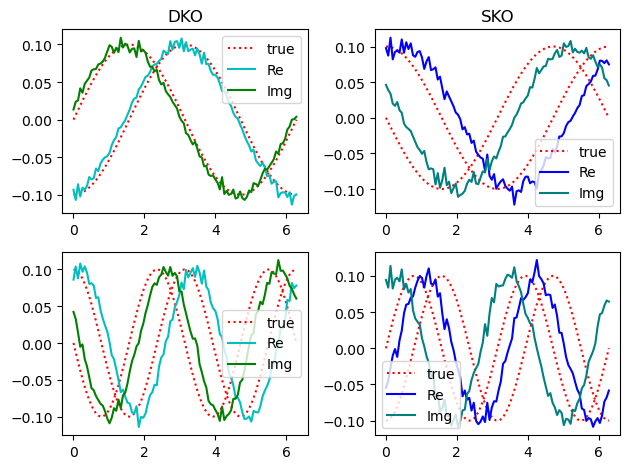

In [72]:
fig, axes = plt.subplots(2, 2, figsize=(6.4, 4.8))  
x = np.linspace(0, 2*np.pi, 100)
axes = np.array(axes).flatten()  


axes[0].plot(x, - 0.1*np.cos(x), 'red', linestyle = ":", label = "true")
axes[0].plot(x, 0.1*np.sin(x), 'red', linestyle = ":")
axes[0].set_title("DKO")
axes[1].plot(x, 0.1*np.cos(x), 'red', linestyle = ":", label = "true")
axes[1].plot(x, -0.1*np.sin(x), 'red', linestyle = ":")
axes[2].plot(x, 0.1*np.cos(2*x), 'red', linestyle = ":", label = "true")
axes[2].plot(x,- 0.1*np.sin(2*x), 'red', linestyle = ":")
axes[1].set_title("SKO")
axes[3].plot(x,- 0.1*np.cos(2*x), 'red', linestyle = ":", label = "true")
axes[3].plot(x, 0.1*np.sin(2*x), 'red', linestyle = ":")
for l in [0, 2]:
    efun_SKO = np.zeros((100, ))
    efun_DKO = np.zeros((100, ))
    for i in range(n):
        efun_DKO = efun_DKO +  evect_DKO[i, l + 1]*np.where((2*np.pi* i/n <=  x) & (2*np.pi*(i + 1)/n >= x), 1, 0)
        efun_SKO = efun_SKO +  evect_SKO[i, l + 1]*np.where((2*np.pi* i/n <=  x) & (2*np.pi*(i + 1)/n >= x), 1, 0)

    axes[l].plot(x, np.real(efun_DKO),'c',  label = "Re")
    axes[l].plot(x, np.imag(efun_DKO), 'g', label = "Img")
    #axes[l].set_title("With eigenvalue" +  str(eval_DKO[l + 1]))
    axes[l].legend()
    
    axes[l + 1].plot(x, np.real(efun_SKO),'b',  label = "Re")
    axes[l + 1].plot(x, np.imag(efun_SKO), 'teal', label = "Img")
    axes[l + 1].legend()
plt.tight_layout()
plt.savefig("eigenvectors_circle.png")

Compute the mean square error in eigenvalues to see which approximation is better
$$MSE  = \frac{1}{n} |\lambda_i - eval[i]|^2$$ where we are looking at the absolute value in the complex plane.

For the error plot we use $N$ data points. FOr SKO it is a long trajectory of length $N$ for DKO it is $K$ trajectories of lenght $2$ for each of the $m$ measures where $m*K = N$

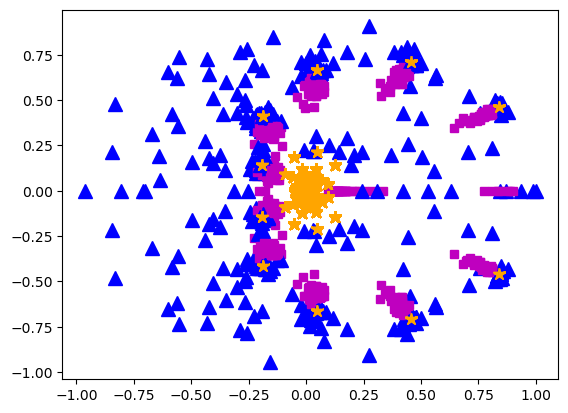

In [82]:
x = np.arange(n)
#true_evals = ((np.cos(x + 1) - 1 + np.sin(x + 1)*1j)/((x + 1)*1j))**Dt
true_evals = np.ravel(np.column_stack((((np.cos(x + 1) - 1 + np.sin(x + 1)*1j)/((x + 1)*1j))**Dt, 
                                      ((np.cos(x + 1) - 1 - np.sin(x + 1)*1j)/((-(x + 1)*1j))**Dt))))
mse_DKO = np.zeros((100, ))
mse_SKO = np.zeros((100, ))

for l in range(1, 101):
    # generate data and compute the eigenvalues for SKO and DKO 
    data_SKO = circle_rotation(0, l**2, 0.5, noise)
    data_DKO_0 = np.zeros((l, l))
    data_DKO_1 = np.zeros((l, l))
    for j in range(l):
        for k in range(l):
            # generate initial condition
            x0 = j* 2 * np.pi / m +  2 * np.pi / m * np.random.uniform()
    
            # store
            data_DKO_0[k, j] = x0
    
            # compute the trajectory
            solution = circle_rotation(x0, Dt + 1, 0.5, noise)
    
            #store
            data_DKO_1[k, j] = solution[-1]
    E_DKO = np.zeros((n, l))
    D_DKO = np.zeros((n, l))
    # for each measure find how many points are within each interval
    for j in range(l):
        counts0, _ = np.histogram(data_DKO_0[:, j], bins = np.linspace(0, 2*np.pi, n + 1))
        E_DKO[:, j] = counts0/l
        counts1, _ = np.histogram(data_DKO_1[:, j], bins = np.linspace(0, 2*np.pi, n + 1))
        D_DKO[:, j] = counts1/l
    K_DKO = D_DKO@np.linalg.pinv(E_DKO)
    E_SKO = np.zeros((n, l**2))
    for i in range(n):
       for j in range(l**2):
            if (2*np.pi* i/n <=  data_SKO[j]) & (data_SKO[j] < 2*np.pi* (i + 1)/n): 
                    E_SKO[i, j] = 1
    K_SKO = E_SKO[:, 1:] @ np.linalg.pinv(E_SKO[:, :-1])
    eval_SKO, _ = np.linalg.eig(K_SKO)
    eval_DKO, _ = np.linalg.eig(K_DKO)
    mse_DKO[l - 1] = np.mean(np.abs(true_evals[:n-1] - eval_DKO[1:])**2)
    mse_SKO[l - 1] = np.mean(np.abs(true_evals[:n-1] - eval_SKO[1:])**2)
    number_evals_to_show = 11
    plt.plot(np.real(eval_SKO[1:number_evals_to_show]), np.imag(eval_SKO[1:number_evals_to_show]), 'b^',markersize=10, label = "SKO")
    plt.plot(np.real(eval_DKO[1:number_evals_to_show]), np.imag(eval_DKO[1:number_evals_to_show]), 'ms',markersize=6, label = "DKO")
    plt.plot(np.real(true_evals), np.imag(true_evals), '*', color='orange', markersize=9, label="true")
    plt.plot(np.real(true_evals), -np.imag(true_evals), '*', color='orange', markersize=9)

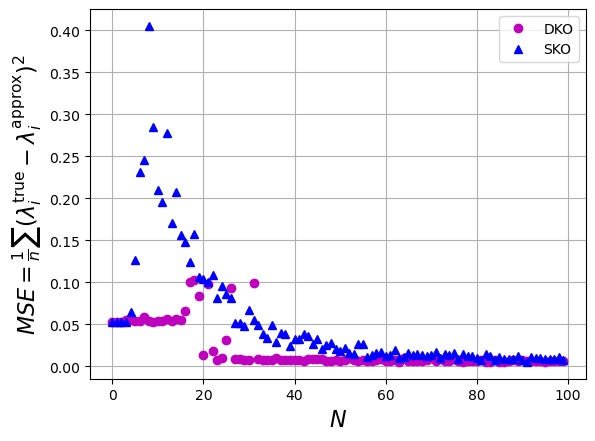

In [93]:
plt.plot(mse_DKO, 'mo', label = "DKO")
plt.plot(mse_SKO,'b^', label = "SKO")
plt.legend()
plt.xlabel("$N$", fontsize=16)
#plt.title("Error as a function of the amout of data")
plt.grid()
plt.ylabel(r"$MSE = \frac{1}{n} \sum(\lambda^{\text{true}}_i - \lambda^{\text{approx}}_i)^2$", fontsize=16)
plt.savefig("error_data.png")

In [94]:
x = np.arange(n)
true_evals = ((np.cos(x + 1) - 1 + np.sin(x + 1)*1j)/((x + 1)*1j))**Dt
true_evals = np.ravel(np.column_stack((((np.cos(x + 1) - 1 + np.sin(x + 1)*1j)/((x + 1)*1j))**Dt, 
                                      ((np.cos(x + 1) - 1 - np.sin(x + 1)*1j)/((-(x + 1)*1j))**Dt))))
#print(true_evals)
mse_DKO = np.zeros((100, ))
mse_SKO = np.zeros((100, ))

noises = np.linspace(0, 1, 100)

for l in range(1, 101):
    # generate data and compute the eigenvalues for SKO and DKO 
    data_SKO = circle_rotation(0, n_SKO, 0.5, noises[l - 1])
    data_DKO_0 = np.zeros((K, m))
    data_DKO_1 = np.zeros((K, m))
    for j in range(m):
        for k in range(K):
            # generate initial condition
            x0 = j* 2 * np.pi / m +  2 * np.pi / m * np.random.uniform()
    
            # store
            data_DKO_0[k, j] = x0
    
            # compute the trajectory
            solution = circle_rotation(x0, Dt + 1, 0.5, noises[l -1])
    
            #store
            data_DKO_1[k, j] = solution[-1]
            
    E_DKO = np.zeros((n, m))
    D_DKO = np.zeros((n, m))
    # for each measure find how many points are within each interval
    for j in range(m):
        counts0, _ = np.histogram(data_DKO_0[:, j], bins = np.linspace(0, 2*np.pi, n + 1))
        E_DKO[:, j] = counts0/K
        counts1, _ = np.histogram(data_DKO_1[:, j], bins = np.linspace(0, 2*np.pi, n + 1))
        D_DKO[:, j] = counts1/K
    K_DKO = D_DKO@np.linalg.pinv(E_DKO)
    E_SKO = np.zeros((n, n_SKO))
    for i in range(n):
       for j in range(n_SKO):
            if (2*np.pi* i/n <=  data_SKO[j]) & (data_SKO[j] < 2*np.pi* (i + 1)/n): 
                    E_SKO[i, j] = 1
    K_SKO = E_SKO[:, 1:] @ np.linalg.pinv(E_SKO[:, :-1])
    eval_SKO, _ = np.linalg.eig(K_SKO)
    eval_DKO, _ = np.linalg.eig(K_DKO)
    #plt.plot(np.real(eval_SKO[1:number_evals_to_show]), np.imag(eval_SKO[1:number_evals_to_show]), 'rx', label = "SKO")
    #plt.plot(np.real(eval_DKO[1:number_evals_to_show]), np.imag(eval_DKO[1:number_evals_to_show]), 'r.', label = "DKO")
    #plt.plot(np.real(true_evals), np.imag(true_evals), 'g.', label = "true")
    #plt.plot(np.real(true_evals), -np.imag(true_evals), 'g.')
    #print(true_evals, eval_DKO[1:])

    mse_DKO[l - 1] = np.mean(np.abs(true_evals[:n-1] - eval_DKO[1:])**2)
    mse_SKO[l - 1] = np.mean(np.abs(true_evals[:n - 1] - eval_SKO[1:])**2)

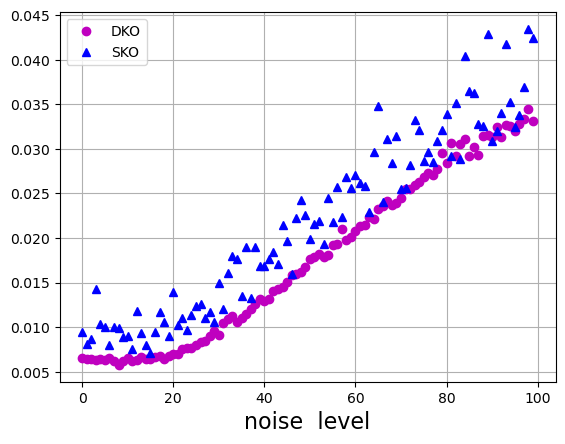

In [98]:
plt.plot(mse_DKO, 'mo', label = "DKO")
plt.plot(mse_SKO,'b^', label = "SKO")
plt.legend()
plt.xlabel("noise  level", fontsize = 16)
#plt.title("Error as a function of noise in the data")
#plt.ylabel(r"$MSE = \frac{1}{n} \sum(\lambda^{\text{true}}_i - \lambda^{\text{approx}}_i)^2$", fontsize=16)

plt.grid()
plt.savefig("errors_noise.png")
# axs + bigger font

#### Variance on the circle

Use the same data set and observables $\hat{h}_l$ for SKO. The DKO observables will be:  $$g_l(\pi) = h_l^2(\pi) - (h_l(\pi))^2 = Var(\hat{h}_l)$$
In order to perform DKO we need to recompute matrices $E = g_l(\pi_j)$ and $D = g_l(\mu_j)$ but now with these new observables. 

In [16]:
E_var = E_DKO - E_DKO**2
D_var = D_DKO - D_DKO**2

K_var = D_var@np.linalg.pinv(E_var)

Text(0.5, 1.0, 'Eigenvalues for variance observables')

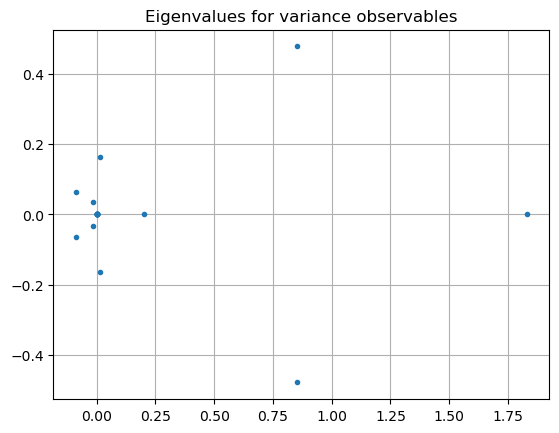

In [17]:
eval_var, evect_var = np.linalg.eig(K_var)
plt.plot(np.real(eval_var), np.imag(eval_var), '.')
plt.grid()
plt.title("Eigenvalues for variance observables")